# Quickstart: Unity RL with PPO
This notebook demonstrates the simplest way to load a pre-trained agent from the Hugging Face hub 
and evaluate it in a Unity Environment using the `rlkit` library. (No manual downloads required)

In [7]:
import torch
import matplotlib.pyplot as plt

# Import project utilities
from utils import PPOAgent, get_repo_tree
from rlkit.envs import UnityEnv, registered_env_list
from rlkit.utils import SimpleMetricModule

## 1. Explore Available Models
First, let's see what pre-trained models are available on the Hugging Face repo.

In [ ]:
tree = get_repo_tree(verbose=True)


[Fetching tree from: notnotDroid/unity-rl/experiments ...]
experiments
├── 3DBall
│   └── ppo
│       └── conf1
│           └── run1 (Run)
├── Crawler
│   └── ppo
│       └── conf1
│           └── run9 (Run)
├── PushBlock
│   └── ppo
│       └── conf1
│           └── run1 (Run)
└── WallJump
    └── ppo
        └── conf1
            └── run2 (Run)



## 2. Load the Agent
We will load a PPO agent. The `PPOAgent` helper automatically downloads the 
config and model weights from Hugging Face if they aren't found locally.

In [6]:
ENV_NAME = 'Crawler'
ALGO = 'ppo'
CONFIG = 'conf1' 
RUN_NAME = 'run9'

print(f"Loading {ENV_NAME} / {ALGO} / {CONFIG} / {RUN_NAME} ...")

agent = PPOAgent(ENV_NAME, CONFIG, RUN_NAME)
policy = agent.get_policy_operator()

print("Agent loaded successfully.")

Loading Crawler / ppo / conf1 / run9 ...
Agent loaded successfully.


## 3. Initialize the Environment
We create the Unity environment wrapper. 
* `graphics=True` allows you to watch the agent in the Unity window.
* `time_scale=1` runs at normal speed (good for watching). Set to 20+ for fast processing.

In [ ]:
env = UnityEnv(
    name=ENV_NAME, 
    graphics=True, 
    time_scale=1, 
    seed=42
)

Avaliable Environments: ['Crawler', 'PushBlock', '3DBall', 'Walker', 'WallJump', 'Worm', 'GridWorld']
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=167772

/opt/homebrew/anaconda3/envs/mlagents/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'continuous_action' is unaccounted for by the transform (expected keys ['PhysicsBodySensor:Body', 'VectorSensor_size32', 'done', 'terminated', 'truncated', 'group_reward', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(


In [15]:
print(f"Avaliable Environments: {registered_env_list}")

Avaliable Environments: ['Crawler', 'PushBlock', '3DBall', 'Walker', 'WallJump', 'Worm', 'GridWorld']


## 4. Run Evaluation
We run a rollout for 1000 steps using the loaded policy.

In [12]:
print("Starting rollout...")
with torch.no_grad():
    # break_when_any_done=False ensures we collect fixed batch size of data
    data = env.rollout(max_steps=1000, policy=policy, break_when_any_done=False)
print("Rollout complete.")

Starting rollout...
Rollout complete.


In [ ]:
# Close the environment to release the unity process
env.close()

## 5. Metrics & Visualization
Calculate the approximate reward and length statistics.


--- Results ---
return: 358.7130
episode_length: 1000.0000
entropy: 5.5710


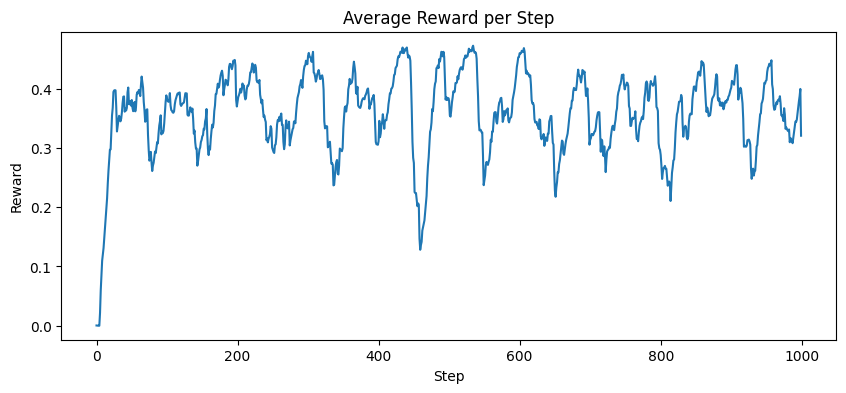

In [13]:
metrics = SimpleMetricModule(mode="approx")(data)

print("\n--- Results ---")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

# Optional: Plot rewards over time if data structure allows
if "next" in data.keys() and "reward" in data["next"].keys():
    rewards = data["next"]["reward"].mean(dim=0).squeeze().cpu().numpy()
    plt.figure(figsize=(10, 4))
    plt.plot(rewards)
    plt.title("Average Reward per Step")
    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.show()